In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
root_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini'
src_dir_path_MSL = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/MSL'
src_dir_path_MITDB = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/MITDB'
src_dir_path_SMD = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SMD'
src_dir_path_LTDB = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/LTDB'
src_dir_path_SVDB = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SVDB'
src_dir_path_OPPORTUNITY = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/OPPORTUNITY'
src_dir_path_SMAP = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SMAP'
src_dir_path_SWaT = '/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SWaT'

In [25]:
# 직접 설정
keywords_to_include = ['000_conv_s15', '001_s15', '002_s15', 's16_baseline', 's16_ternary_runtime_gpu', 's15_baseline_gpu', 's16_baseline_gpu', 'ternary_runtime_cpu']
keywords_to_exclude = ['delta', 'repeat']
model_names = []

In [26]:
# keywords를 포함하는 파일만 각 디렉토리에서 선택
def get_files_with_keywords(src_dir_path, keywords_to_include, keywords_to_exclude=None):
    files = []
    model_names = []
    for root, dirs, filenames in os.walk(src_dir_path):
        for filename in filenames:
            if any(keyword_in in filename for keyword_in in keywords_to_include):
                files.append(os.path.join(root, filename))
                parts = filename.split('_')
                # parts[2]부터 끝까지 모델 이름으로 사용, 확장자 제거
                model_name = os.path.splitext('_'.join(parts[1:]))[0]
                model_names.append(model_name)
    # 제외 키워드 필터링: keywords_to_exclude가 포함된 모델들은 제거
    if keywords_to_exclude:
        filtered_files = []
        filtered_model_names = []
        for f, m in zip(files, model_names):
            if not any(ex in m for ex in keywords_to_exclude):
                filtered_files.append(f)
                filtered_model_names.append(m)
        return filtered_files, filtered_model_names
    return files, model_names
# 각 디렉토리에서 파일 선택
file_paths_MSL, model_names_MSL = get_files_with_keywords(src_dir_path_MSL, keywords_to_include, keywords_to_exclude)
file_paths_MITDB, model_names_MITDB = get_files_with_keywords(src_dir_path_MITDB, keywords_to_include, keywords_to_exclude)
file_paths_SMD, model_names_SMD = get_files_with_keywords(src_dir_path_SMD, keywords_to_include, keywords_to_exclude)
file_paths_LTDB, model_names_LTDB = get_files_with_keywords(src_dir_path_LTDB, keywords_to_include, keywords_to_exclude)
file_paths_SVDB, model_names_SVDB = get_files_with_keywords(src_dir_path_SVDB, keywords_to_include, keywords_to_exclude)
file_paths_OPPORTUNITY, model_names_OPPORTUNITY = get_files_with_keywords(src_dir_path_OPPORTUNITY, keywords_to_include, keywords_to_exclude)
file_paths_SMAP, model_names_SMAP = get_files_with_keywords(src_dir_path_SMAP, keywords_to_include, keywords_to_exclude)
file_paths_SWaT, model_names_SWaT = get_files_with_keywords(src_dir_path_SWaT, keywords_to_include, keywords_to_exclude)

In [27]:
metrics_columns = 'Time,AUC-PR,AUC-ROC,VUS-PR,VUS-ROC,Standard-F1,PA-F1,Event-based-F1,R-based-F1,Affiliation-F'.split(',')

In [28]:
metrics_columns = ['Time', 'VUS-PR']

In [29]:
def plot_metrics_comparison(file_paths, model_names, metrics_columns, title):
    # ensure matching lengths
    if len(file_paths) != len(model_names):
        raise ValueError(f"file_paths length {len(file_paths)} != model_names length {len(model_names)} for {title}")
    import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

    # Read and process each CSV
    dfs = []
    for fp in file_paths:
        df = pd.read_csv(fp).drop(columns=['file'])
        if len(df) > 1:
            df = pd.DataFrame([df.mean()])
        dfs.append(df)

    combined = pd.concat(dfs, ignore_index=True)
    combined.index = model_names

    # Filter out metrics not in data
    metrics_columns = [m for m in metrics_columns if m in combined.columns]
    if not metrics_columns:
        raise ValueError(f"No matching metrics found for {title}")

    # Subplot grid
    n_metrics = len(metrics_columns)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))
    fig.suptitle(title)
    axes = axes.flatten()

    # Color palette per model
    colors = sns.color_palette('tab20', len(model_names))  # changed: use tab20 for more distinct colors
    palette = dict(zip(model_names, colors))

    for i, metric in enumerate(metrics_columns):
        ax = axes[i]
        data = combined[metric].dropna()
        if data.empty:
            continue
        # sort values and index together
        sorted_vals = data.sort_values(ascending=False)
        sorted_idx = list(sorted_vals.index)
        import numpy as np  # changed code
        positions = np.arange(len(sorted_vals))  # added: assign unique x positions
        bars = ax.bar(positions, sorted_vals.values, color=[palette[m] for m in sorted_idx])  # changed code
        # annotate
        ax.set_ylim(0, sorted_vals.values.max() * 1.1)
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h, f"{h:.4f}",
                    ha='center', va='bottom', color='black')
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        if len(model_names) > 5:
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_xticks(positions)  # added: use numeric positions for ticks
        ax.set_xticklabels(sorted_idx)  # added: re-assign model names as tick labels

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

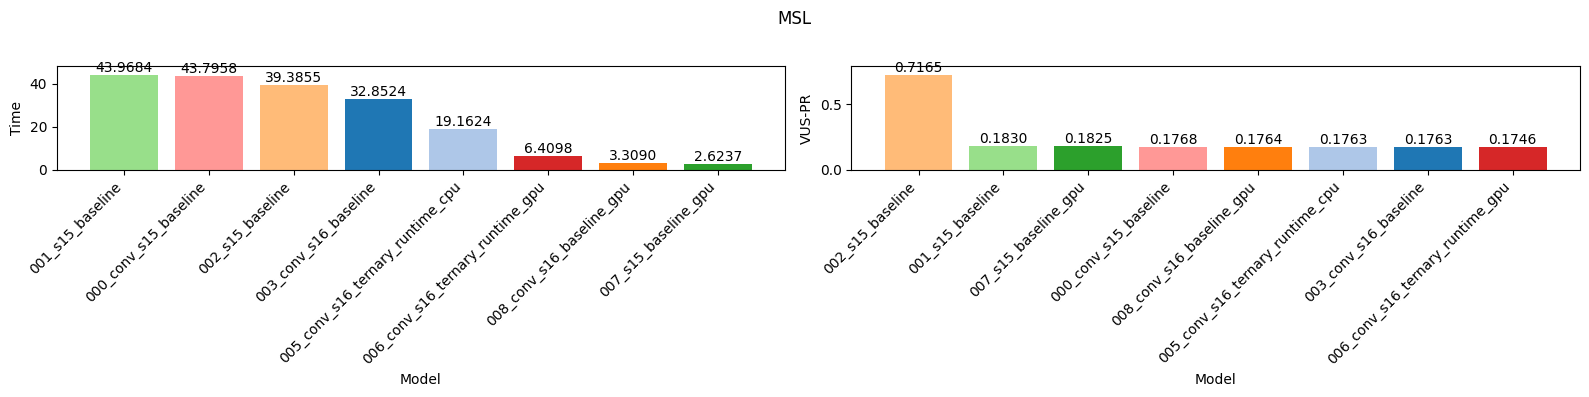

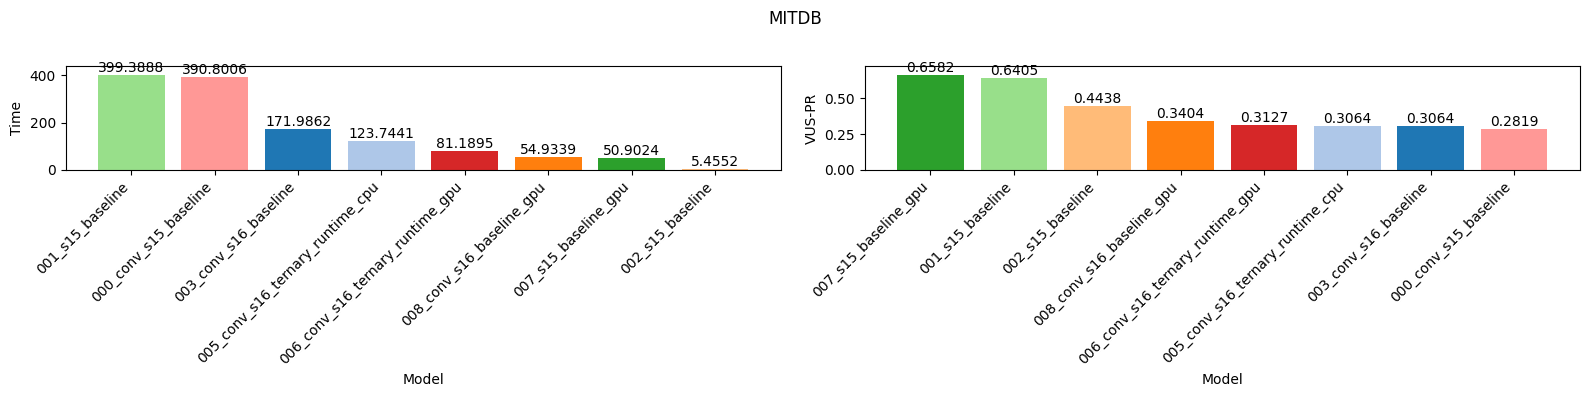

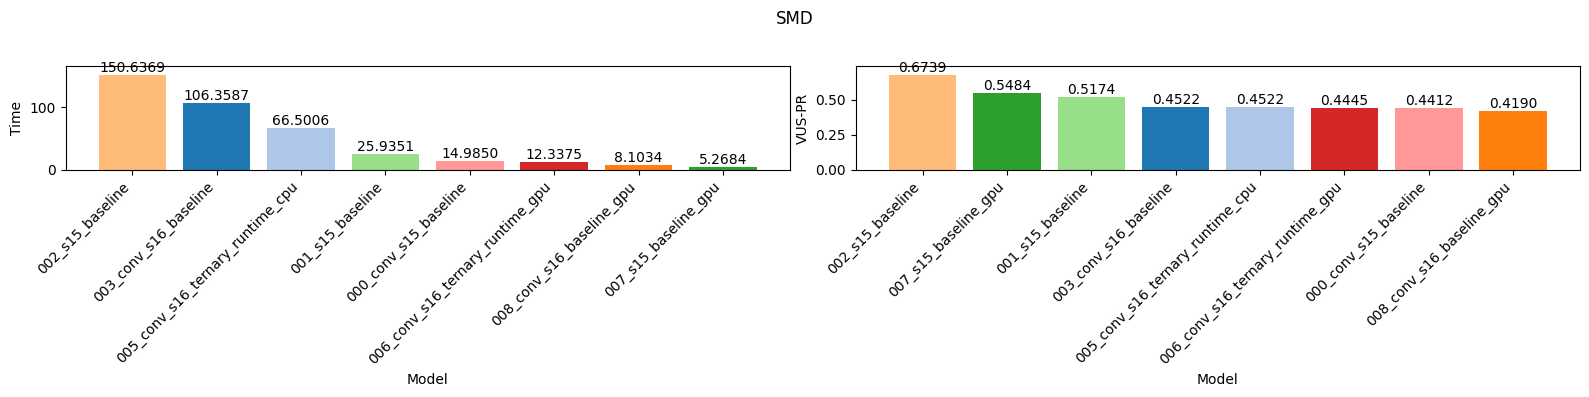

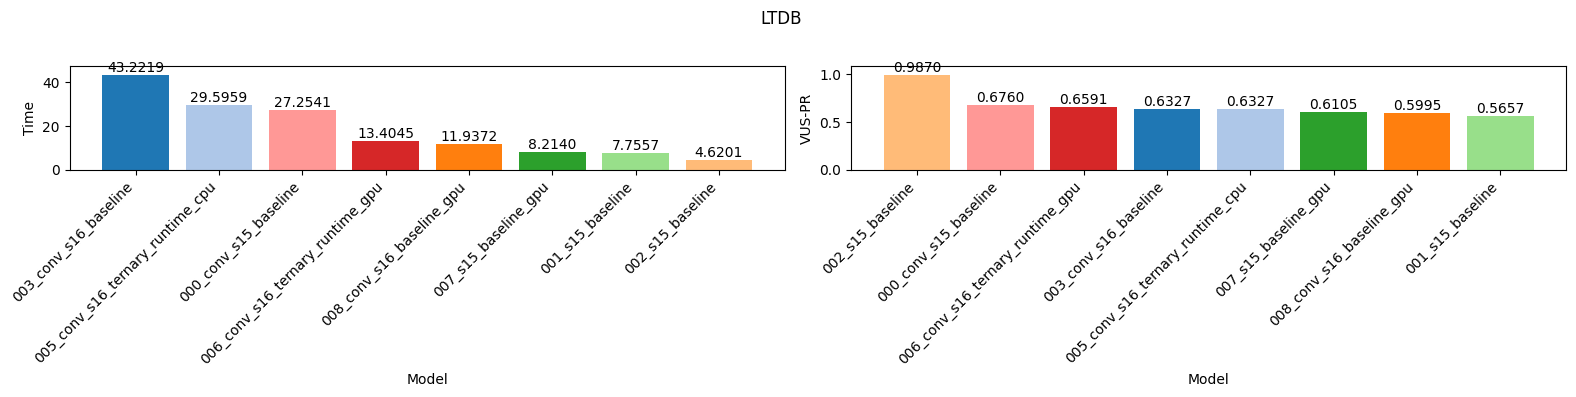

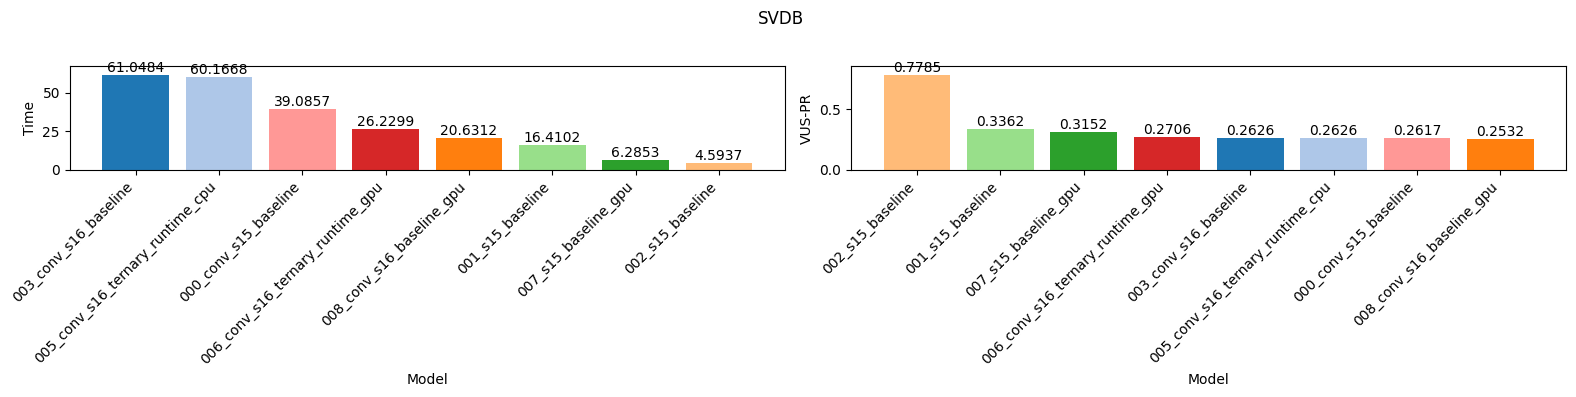

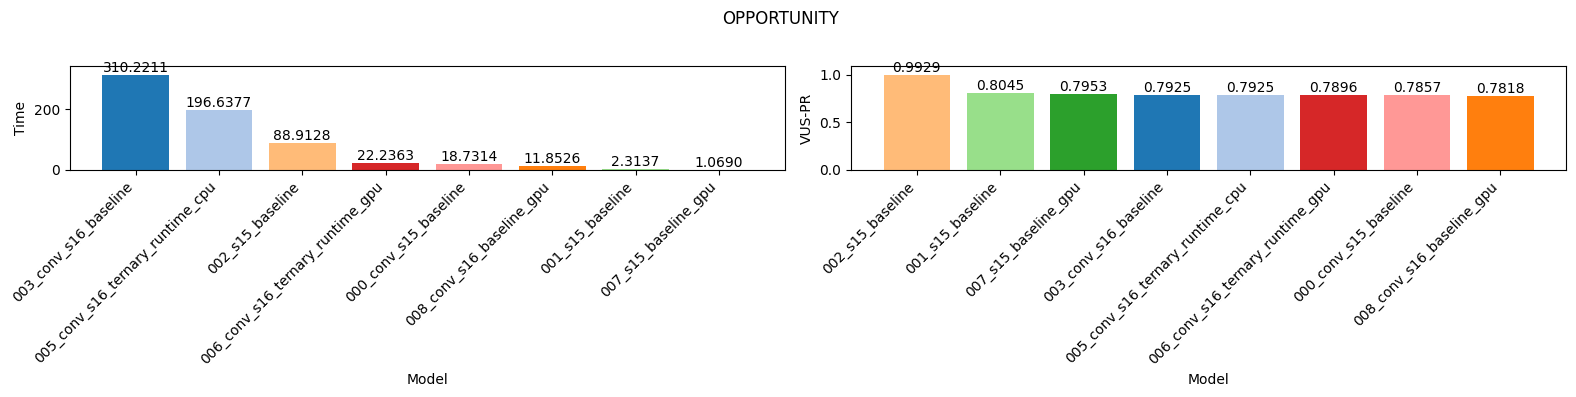

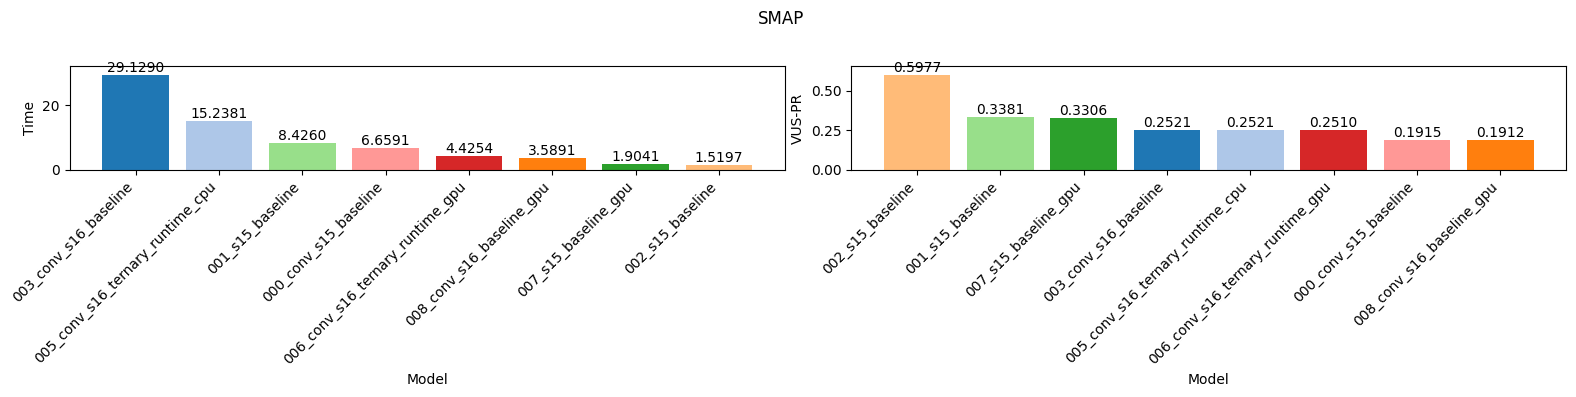

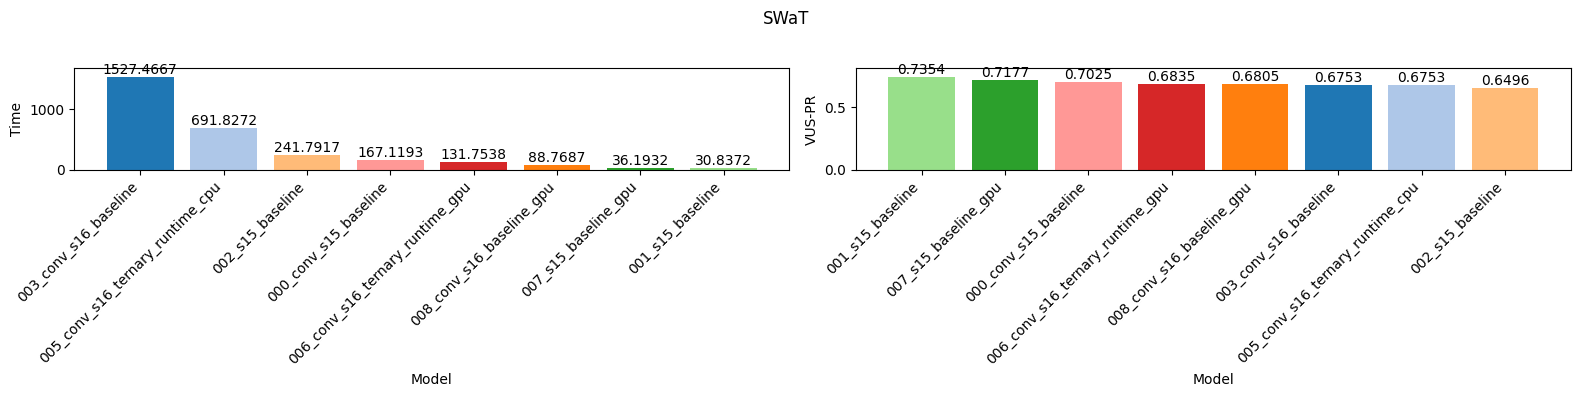

In [30]:
plot_metrics_comparison(file_paths_MSL, model_names_MSL, metrics_columns, 'MSL')
plot_metrics_comparison(file_paths_MITDB, model_names_MITDB, metrics_columns, 'MITDB')
plot_metrics_comparison(file_paths_SMD, model_names_SMD, metrics_columns, 'SMD')
plot_metrics_comparison(file_paths_LTDB, model_names_LTDB, metrics_columns, 'LTDB')
plot_metrics_comparison(file_paths_SVDB, model_names_SVDB, metrics_columns, 'SVDB')
plot_metrics_comparison(file_paths_OPPORTUNITY, model_names_OPPORTUNITY, metrics_columns, 'OPPORTUNITY')
plot_metrics_comparison(file_paths_SMAP, model_names_SMAP, metrics_columns, 'SMAP')
plot_metrics_comparison(file_paths_SWaT, model_names_SWaT, metrics_columns, 'SWaT')

In [31]:
def plot_all_datasets_comparison(timeseries_names, all_file_paths, model_names, metric='VUS-PR'):
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    import numpy as np
    plt.figure(figsize=(10,6))

    results_on_each_model = {}
    for model_name in model_names:
        results_on_each_model[model_name] = []
        for file_path in all_file_paths:
            if model_name in file_path:
                df = pd.read_csv(file_path)
                if metric in df.columns:
                    results_on_each_model[model_name].append(df[metric].mean())
                else:
                    results_on_each_model[model_name].append(np.nan)

    # assign distinct colors using a colormap
    colors = plt.cm.tab20(np.linspace(0, 1, len(model_names)))
    for i, (model_name, results) in enumerate(results_on_each_model.items()):
        plt.plot(timeseries_names, results, marker='o', label=model_name, color=colors[i])

    plt.xlabel('Timeseries')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison Across Datasets')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout()
    plt.show()

In [32]:
datasets = ['MSL', 'MITDB', 'SMD', 'LTDB', 'SVDB', 'OPPORTUNITY', 'SMAP', 'SWaT']

# 모든 리스트의 원소를(e.g. file_paths_PSM)를 하나의 리스트로 결합
all_file_paths = file_paths_MSL + file_paths_MITDB + file_paths_SMD + file_paths_LTDB + file_paths_SVDB + file_paths_OPPORTUNITY + file_paths_SMAP + file_paths_SWaT

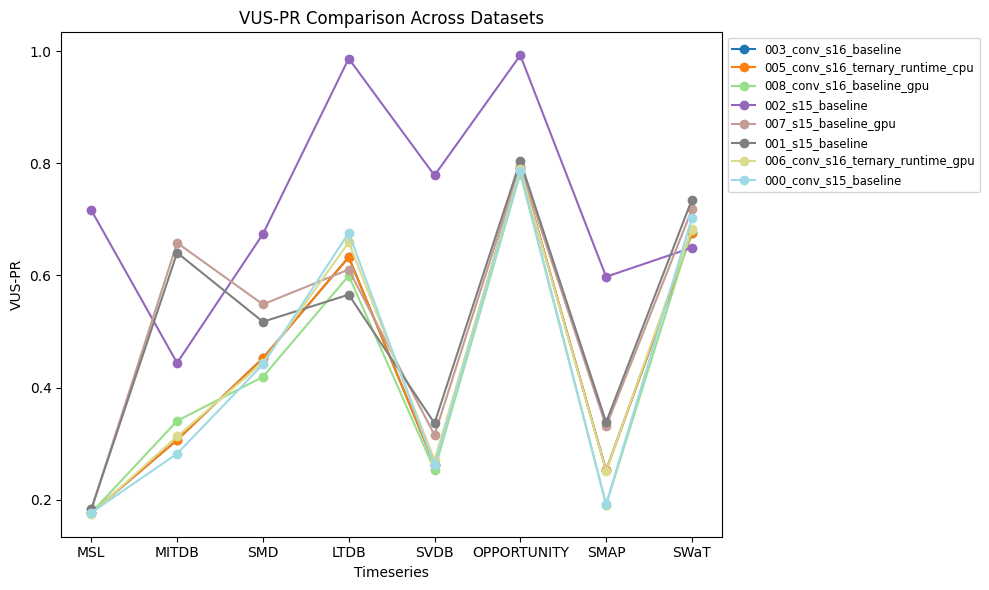

In [33]:
plot_all_datasets_comparison(datasets, all_file_paths, model_names_MSL, 'VUS-PR')

In [34]:
# root_dir_path에서 keywords_to_include가 포함된 모든 파일을 찾고, 각 파일의 'VUS-PR'열의 평균을 계산하여 차례대로 출력
def get_all_files_with_keywords(root_dir_path, keywords_to_include):
    
    file_names = os.listdir(root_dir_path)
    # skip directories
    file_names = [f for f in file_names if os.path.isfile(os.path.join(root_dir_path, f))]
    # filter files based on keywords
    all_files = []
    for file_name in file_names:
        if any(keyword in file_name for keyword in keywords_to_include):
            all_files.append(os.path.join(root_dir_path, file_name))
    
    return all_files

def calculate_average_VUS_PR(all_files):
    results = {}
    for file_path in all_files:
        df = pd.read_csv(file_path)
        if 'VUS-PR' in df.columns:
            avg_VUS_PR = df['VUS-PR'].mean()
            results[file_path] = avg_VUS_PR
    return results

all_files = get_all_files_with_keywords(root_dir_path, keywords_to_include)
average_VUS_PR_results = calculate_average_VUS_PR(all_files)

# Sort the results by average VUS-PR
sorted_results = sorted(average_VUS_PR_results.items(), key=lambda x: x[1], reverse=True)
# Print the sorted results
for file_path, avg_VUS_PR in sorted_results:
    print(f"{file_path}: {avg_VUS_PR:.4f}")

/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/PCA_002_s15_baseline.csv: 0.7151
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/CNN_001_s15_baseline.csv: 0.4001
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/CNN_007_s15_baseline_gpu.csv: 0.3941
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SpikeCNN_006_conv_s16_ternary_runtime_gpu.csv: 0.3315
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SpikeCNN_003_conv_s16_baseline.csv: 0.3278
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SpikeCNN_005_conv_s16_ternary_runtime_cpu.csv: 0.3278
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SpikeCNN_000_conv_s15_baseline.csv: 0.3124
/home/hwkang/dev-TSB-AD/TSB-AD/eval/mini/SpikeCNN_008_conv_s16_baseline_gpu.csv: 0.3052
